# Toy Problem #1


Approach: Read the data in from the csv files.

- Create a GeoDataFrame object out of this
- Create a dual graph so that each node represents a street and the geometries between them
- Use VRP process on nodes

New Heuristics Approach: based on https://researchrepository.wvu.edu/cgi/viewcontent.cgi?article=5362&context=etd



# Step 1 - Read Data and Create Graph

In [2]:
import networkx as nx
import math
import pandas as pd
import random
import osmnx as ox
import geopandas as gpd
import momepy
import matplotlib.pyplot as plt
import itertools
import numpy as np

c:\Users\Sneez\Desktop\Snowplowing\Snowplow-Routing-Code\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read the edges and nodes

In [3]:
edgelist = pd.read_csv("edges.csv")
nodelist = pd.read_csv("nodes.csv")

Create graph

In [4]:
G = nx.Graph()
for i,edges in edgelist.iterrows():
    G.add_edge(edges.iloc[0],edges.iloc[1],**edges.iloc[2:].to_dict())

for i,nodes in nodelist.iterrows():
    attributes = nodes[1:].to_dict()
    nx.set_node_attributes(G, {nodes['id']:  attributes})  


Take a step back and visualize the data in our graph

In [5]:
print('# of edges: {}'.format(G.number_of_edges()))
print('# of nodes: {}'.format(G.number_of_nodes()))

print(G.edges(data=True))
print(G.nodes(data=True))

# of edges: 6
# of nodes: 5
[('depot', 'home', {'distance': 1, 'priority': 1, 'time': 1, 'passes_rem': 1, 'salt_per': 1}), ('depot', 'school', {'distance': 2, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1}), ('depot', 'grocery', {'distance': 7, 'priority': 2, 'time': 7, 'passes_rem': 1, 'salt_per': 3}), ('school', 'grocery', {'distance': 5, 'priority': 2, 'time': 5, 'passes_rem': 1, 'salt_per': 2}), ('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes_rem': 2, 'salt_per': 2}), ('grocery', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes_rem': 2, 'salt_per': 1})]
[('depot', {'x': 0, 'y': 0}), ('home', {'x': 1, 'y': 0}), ('school', {'x': 0, 'y': 2}), ('grocery', {'x': 5, 'y': 2}), ('hospital', {'x': 3, 'y': 7})]


##### Visualize the Graph

In [6]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['x'], node[1]['y']) for node in G.nodes(data=True)}
# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])


{'depot': (0, 0),
 'home': (1, 0),
 'school': (0, 2),
 'grocery': (5, 2),
 'hospital': (3, 7)}

Now plot

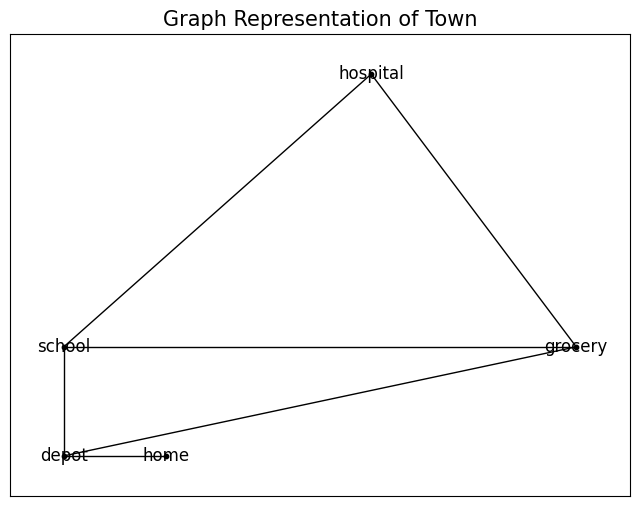

In [7]:
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True)
plt.title('Graph Representation of Town', size=15)
plt.show()

Visualize Paramters

In [8]:
for edge in G.edges(data=True):
    print(edge)

('depot', 'home', {'distance': 1, 'priority': 1, 'time': 1, 'passes_rem': 1, 'salt_per': 1})
('depot', 'school', {'distance': 2, 'priority': 1, 'time': 2, 'passes_rem': 1, 'salt_per': 1})
('depot', 'grocery', {'distance': 7, 'priority': 2, 'time': 7, 'passes_rem': 1, 'salt_per': 3})
('school', 'grocery', {'distance': 5, 'priority': 2, 'time': 5, 'passes_rem': 1, 'salt_per': 2})
('school', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes_rem': 2, 'salt_per': 2})
('grocery', 'hospital', {'distance': 3, 'priority': 3, 'time': 3, 'passes_rem': 2, 'salt_per': 1})


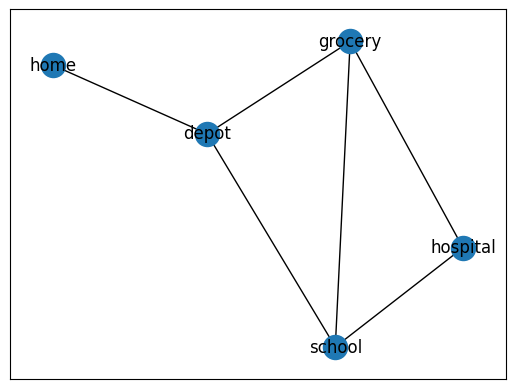

In [9]:
# Set the seed for the spring layout
spring_pos = nx.spring_layout(G, seed=1)

# Draw the graph using the spring layout
nx.draw_networkx(G, pos=spring_pos, with_labels=True)
plt.show()

# Step 2: Route Construction Algorithm (RCA)

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  RCL |  Restricted Candidate List |
|  $\alpha$   |  Threshold parameter. Value between 0 and 1  
|  C<sub>min   | Lowest incremental cost of a candidate element to be added to the partial solution    |
| C<sub>max | Highest incremental cost of a candidate element to be added to the partial solution|
| S_i | Amount of salt required to service road i |
|E| List of possible candidates that can be added to the partial solution
|No_Routes|Number of routes developed in the network



Adding salt considerations.

Overview:
1. If there is at least one required arc from the current node, then create a restricted candidate list based on the neighbors of the current node. Otherwise go to step 3
2. If RCL is empty, go to step 3. Otherwise choose a random arc from the RCL based on the threshold parameter and cost range
3. Go through the list of all required arcs and find the closest one.
4. Service that arc, subtracting one from the effective degree of the current node
5. Update the current node to the new node

## Defining a Class for the Routes

We want to keep track of certain attributes of each traversed edge for backtracking purposes. Let's create a class to manage all the variables

In [10]:
class RouteStep:
    """
    Represents a step in a route.

    Attributes:
        node1 (str): The starting node of the step.
        node2 (str): The ending node of the step.
        wasDeadheaded (bool): Indicates whether the step was a deadhead (empty) move.
        hadOptions (bool): Indicates whether the step had multiple options for routing. Could have gone a different direction
        saltval (int): Indicates the amount of salt the vehicle had before traversing the arc. Useful for checking validity of solution
    """
    def __init__(self, node1="", node2="", wasDeadheaded=False, hadOptions=False, saltval = 0):
        self.node1 = node1
        self.node2 = node2
        self.wasDeadheaded = wasDeadheaded
        self.hadOptions = hadOptions
        self.saltval = saltval

    def __str__(self):
        return f"{self.node1} --> {self.node2}. Deadhead: {self.wasDeadheaded}. Had options: {self.hadOptions}. Salt value: {self.saltval}"

    def __repr__(self):
        return str(self)


## Identifying Turn Directions at an Intersection

Methodology: Use coordinate system. Identify the three coordinates of the triangle (can be degenerate) that every turn makes. Potential for linear algebra: dot product of the two vectors, or change of basis?

Example: going from (2,1) to (0,1) to (-1,-1)

v = [-2, 0]
w = [-1, -2]

Create a function that computes the signed angle between any two vectors

In [11]:
from math import atan2
from math import pi
def angle(v, w):
    '''
    Computes the signed angle (in degrees) between two vectors v and w
    '''
    dot = v[0]*w[0] + v[1]*w[1]     # Dot product between [x1, y1] and [x2, y2]
    det = v[0]*w[1] - v[1]*w[0]      # Determinant
    angle = atan2(det, dot)  # atan2(y, x) or atan2(sin, cos)

    return angle*180/pi

v=(1,0)
w=(0,-1)

angle(v,w)


-90.0

Using the angle, identify whether the turn is straight, left, right, or backwards. See diagram for reference
<img src="turn_categorization.jpg" alt="Turn Categorization Based on Angle" />


In [12]:
def turn_direction(angle):
    '''
    Returns the direction of a turn given an angle
    '''
    if angle < 15 and angle > -15:
        return "straight"
    elif angle >= -90 and angle <= -15:
        return "right"
    elif angle <= 90 and angle >= 15:
        return "left"
    elif angle <= 135 and angle > 90:
        return "sharp left"
    elif angle >= -135 and angle < -90:
        return "sharp right"
    else:
        return "u-turn"


71.56505117707799 left


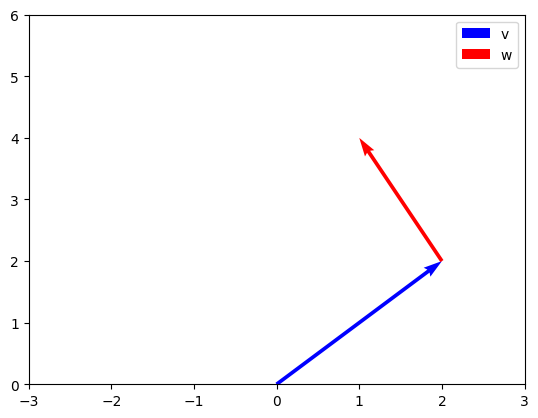

In [13]:
v=(2,2)
w=(-1,2)
theta = angle(v,w)
print(theta, turn_direction(theta))

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the vectors
ax.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='blue', label='v')
ax.quiver(v[0], v[1], w[0], w[1], angles='xy', scale_units='xy', scale=1, color='red', label='w')

# Set the x and y limits
ax.set_xlim([-3, 3])
ax.set_ylim([0, 6])

# Add a legend
ax.legend()

# Show the plot
plt.show()

Initialize model parameters

In [14]:
number_of_routes = 0 # set initial number of routes to zero
curr_node = 'depot' # set starting node to depot
alpha = 0.4 # set alpha parameter
SALT_CAP = 5 # fixed salt cap of the vehicle

### Adding useful graph attributes

Update the effective degree of all nodes. If $v$ is the vertice and $E_v$ is the set of all edges leaving from $v$, then the effective degree is 
$$\text{Deg(v)} = \sum_{e \in E_v} e(\text{passes})$$

Also, calculate the weighted degree of each node, defined as
$$\text{WeightedDeg(v)} = \sum_{e \in E_v} e(\text{passes})\cdot e(\text{priority})$$

Also, update the total amount of salting required for the road given the number of passes

In [15]:
def config_graph_attributes(G):
    for node in G.nodes:
        weight_deg = 0
        for edge in G.edges([node], data=True):
            weight_deg += edge[2]['passes_rem']*edge[2]['priority']
        G.nodes[node]['weighted_degree'] = weight_deg
    # add a new attribute to each edge, called "deadheading_passes" and initially set to 0
    for edge in G.edges(data=True):
        edge[2]['deadheading_passes'] = 0


config_graph_attributes(G)
# print result
for node in G.nodes(data=True):
    print(node)

('depot', {'x': 0, 'y': 0, 'weighted_degree': 4})
('home', {'x': 1, 'y': 0, 'weighted_degree': 1})
('school', {'x': 0, 'y': 2, 'weighted_degree': 9})
('grocery', {'x': 5, 'y': 2, 'weighted_degree': 10})
('hospital', {'x': 3, 'y': 7, 'weighted_degree': 12})


Calculate shortest distance between each pair of nodes in the network using
Floyd's algorithm and visualize distance matrix

Define a cost function for traversing an arc

In [16]:
def cost(G, node1, node2):
    '''
    Returns the cost of traversing an edge between two nodes. Doesn't include priorities yet. 
    Currently based solely on distance.
    '''
    edge_data = G.get_edge_data(node1, node2)

    cost = edge_data['distance']
    return cost

In [17]:
def needs_servicing(G, node1, node2):
    '''
    Returns whether or not the edge between two nodes requires servicing
    '''
    return G[node1][node2]['passes_rem'] > 0

### Start finding a route

Check if there are any required arcs remaining departing from the current node

In [18]:
def visit_arc(G: nx.Graph, arc: tuple, route: list, options: bool, undirected=True):
    global curr_salt
    '''
    Visits an arc and updates the route and cost. Returns the new node that the arc is on
    
    Parameters:
        G (networkx.Graph): The graph representing the network
        arc (tuple): The arc to be visited
        route (list): The partial route taken so far (default: partial_route)
        undirected (bool): Flag indicating if the graph is undirected (default: True)
    
    Returns:
        int: The new node that the arc is on
    '''
    # initialize routstep object
    route_step = RouteStep(arc[0], arc[1], hadOptions=options, saltval=curr_salt)

    # not deadheading. So we service the arc and update the effective degree of the relevant node
    # need a check to see if we can actually service the arc given the amount of salt we have left.
    salt_required = G[arc[0]][arc[1]]['salt_per']

    # needs servicing and we can service it. Update weighted and effective degree
    if needs_servicing(G, arc[0], arc[1]) and curr_salt >= salt_required:
        G.nodes[arc[0]]['weighted_degree'] -= G[arc[0]][arc[1]]['priority']

        if (undirected):
            G.nodes[arc[1]]['weighted_degree'] -= G[arc[0]][arc[1]]['priority']

        curr_salt -= salt_required
        G[arc[0]][arc[1]]['passes_rem'] -= 1 # mark that we traversed this arc
        route_step.wasDeadheaded = False
    else:
        G[arc[0]][arc[1]]['deadheading_passes'] += 1
        route_step.wasDeadheaded = True
    route.append(route_step)
    return arc[1]

In [19]:
def process_node(G, curr_node):
    '''
    Returns a list of required arcs that depart from curr_node, as well as the minimum and maximum cost
    of all departing arcs
    '''
    c_min = math.inf
    c_max = -math.inf

    required = []
    for edge in G.edges([curr_node], data=True):
        if edge[2]["passes_rem"] > 0:
            required.append(edge)
            c_min = min(cost(G, edge[0], edge[1]), c_min)
            c_max = max(cost(G, edge[0], edge[1]), c_max)
    return required, c_min, c_max

In [20]:
def move_between_nodes(G, node1, node2, route_up_to_now):
    '''
    Moves between two nodes via the shortest path, updating any required arcs along the way. 
    Works for non-multigraphs. Requires modification when doing it for multigraphs since floyd_warshall
    only returns nodes, not edges in the shortest path.
    '''
    predecessors, distances = nx.floyd_warshall_predecessor_and_distance(G,weight="distance")
    node_path = nx.reconstruct_path(node1, node2, predecessors)
    
    edges = list()
    for i in range(len(node_path)-1):
        edges.append((node_path[i], node_path[i+1]))

    for edge in edges:
        visit_arc(G, edge, options=False, route=route_up_to_now)

In [21]:
def has_edge_within_capacity(G, node):
    global curr_salt
    if curr_salt == 0:
        return False
    for neighbor in G[node]:
        if G[node][neighbor]['salt_per'] <= curr_salt and G[node][neighbor]['passes_rem'] > 0:
            return True
    return False

def find_nearest_required(G, node):
    '''
    Finds the path to the nearest node with a required arc to traverse.
    '''
    predecessors, distances = nx.floyd_warshall_predecessor_and_distance(G,weight="distance")
    # get the 1d numpy array corresponding to the distances from the node to all other nodes
    dists = distances[node]

    # loop through the dists array and find the nearest required arc
    min_dist = math.inf
    min_dist_node = None
    for n in G.nodes():
        if n == node:
            continue
        if G.nodes[n]['weighted_degree'] > 0 and dists[n] < min_dist:
            # check that the node has an edge to service within salt capacity
            if has_edge_within_capacity(G, n):
                min_dist = dists[n]
                min_dist_node = n
    
    if min_dist_node is None:
        return None
    # reconstruct path
    node_path = nx.reconstruct_path(node, min_dist_node, predecessors)
    edges = list()
    for i in range(len(node_path)-1):
        edges.append((node_path[i], node_path[i+1]))

    return edges
        

Add an arc to the RCL if it has a cost in the range 
$$R = [C_{min}, C_{min} + \alpha \cdot (C_{max}-C_{min})]$$

Determine C<sub>min</sub> and C<sub>max</sub> by looping through first.

A value of alpha close to zero means that we will almost always choose the least cost arc (think greedy), while value close to one means the choice will be virtually random. Alpha=zero is nearest neighbor heuristic

To choose an arc from the RCL, we either randomly choose or weight based on turn direction and degree of the next intersection.

Parameter: Weights is the amount of weight assigned to turning, degree, and priority. Total weight is 

$$(\text{weights[0]}) \cdot \text{turns} + (\text{weights[1]})\cdot \text{degree} + (\text{weights[2]})\cdot \text{priority}$$

Continue running the route construction algorithm until there are no required nodes in the graph left. Run the algorithm on a copy of G so that the original graph is preserved

In [22]:
def chooseArc(G, rcl, prev_node, weights):
    """
    Selects an arc from a Restricted Candidate List (RCL) based on various weights.

    Parameters:
    - G: The graph representing the road network.
    - rcl: The Restricted Candidate List (RCL) containing the arcs to choose from.
    - prev_node: The previous node in the path.
    - weights: A list of weights used to calculate the arc selection probabilities. The first weight is for turn direction, the second weight is for the degree of the next node, and the third weight is for the priority of the arc.
    Precondition: sum of weights is 1.

    Returns:
    - The selected arc from the RCL.

    Algorithm:
    1. If the previous node is None or a random number is greater than 0.8, choose an arc randomly from the RCL.
    2. Calculate weights for each arc in the RCL based on turn direction, degree of the next node, and priority.
    3. Normalize the sum of the weights.
    4. Choose an arc based on the weights, where higher weights are more likely to be chosen.

    Note:
    - The angle, turn_direction, and angle functions are assumed to be defined elsewhere.

    """

    # randomize 20% of the time
    if (random.random() > .8):
        return random.choice(rcl)
    
    turn_weights = {"straight": 6, "right": 5, "left": 4, "sharp right": 3, "sharp left": 2, "u-turn": 1}
    weights_turns = np.empty(len(rcl))
    weights_degrees = np.empty(len(rcl))
    weights_priority = np.empty(len(rcl))

    # calculate weights by turn direction, degree of next node, and priority
    i = 0
    for edge in rcl:
        curr_node = edge[0]
        next_node = edge[1]

        # only calculate turn direction if there is a previous node
        if prev_node is not None:
            v_x = G.nodes[curr_node]['x']-G.nodes[prev_node]['x']
            v_y = G.nodes[curr_node]['y']-G.nodes[prev_node]['y']

            w_x = G.nodes[next_node]['x']-G.nodes[curr_node]['x']
            w_y = G.nodes[next_node]['y']-G.nodes[curr_node]['y']

            v = (v_x, v_y)
            w = (w_x, w_y)

            theta = angle(v,w)

            weights_turns[i] = (turn_weights[turn_direction(theta)])
        weights_degrees[i] = G.nodes[next_node]['weighted_degree']
        weights_priority[i] = G[curr_node][next_node]['priority']
        i+=1


    # normalize the sum of the weights
    weights_degrees = weights_degrees / np.sum(weights_degrees)
    weights_priority = weights_priority / np.sum(weights_priority)

    if prev_node is not None:
        weights_turns = weights_turns / np.sum(weights_turns)
        weights_tot = weights[0]*weights_turns + weights[1]*weights_degrees + weights[2]*weights_priority
    # if there is no previous node, we are at depot, so turn direction doesn't matter.
    else:
        weights_tot = weights[1]*weights_degrees + weights[2]*weights_priority
        weights_tot = weights_tot / np.sum(weights_tot)
    
    # choose an arc based on the weights (higher weights are more likely to be chosen)
    index = int(np.random.choice(np.linspace(0,len(rcl)-1,len(rcl)), p=weights_tot))
    # print("Weights", weights_tot, "prev node is none?", prev_node is None)
    # print("choice: ", rcl[index][0], rcl[index][1])
    # print("RCl was ", [(edge[0], edge[1]) for edge in rcl])
    return rcl[index]


In [23]:
def RCA(G, curr_node, alpha, arc_selection_weights, route: list[RouteStep]):
    global curr_salt
    while True:
        required_arcs, c_min, c_max = process_node(G, curr_node)
        rcl = [] # initialize restricted candidate list
        
        for edge in required_arcs:
            if cost(G, edge[0], edge[1]) >= c_min and cost(G, edge[0], edge[1]) <= c_min + alpha*(c_max-c_min) and G[edge[0]][edge[1]]['salt_per'] <= curr_salt:
                rcl.append(edge)
        
        # chooes an arc based on restricted candidate list if not empty
        if len(rcl) > 0:
            multiple_neighbors = len(rcl) > 1
            prev_node = route[-1].node1 if len(route) > 0 else None
            
            chosen_arc = chooseArc(G, rcl, prev_node, arc_selection_weights)
            curr_node = visit_arc(G, chosen_arc, options=multiple_neighbors, route=route)

        # if restricted candidate list is empty, follow path to nearest node with required arc
        else:
            path = find_nearest_required(G, curr_node)
            # no more required arcs in the graph that we can service, so we're done.
            # return to the depot and refill salt cap
            if path is None:
                move_between_nodes(G, curr_node, 'depot', route)
                return route
            
            # otherwise go to the arc to visit
            for edge in path:
                multiple_neighbors = len(G[curr_node]) > 1
                curr_node = visit_arc(G, edge, options=False, route=route)
                if curr_node == 'depot':
                    return route
        # if we're at the depot for any reason, that's the end of a route.
        if curr_node == 'depot':
            return route

In [24]:
def all_serviced(G):
    for node in G.nodes():
        if G.nodes[node]['weighted_degree'] > 0:
            return False
    return True

Generate routes

In [25]:
# define initial conditions
curr_node = 'depot' # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_copy = G.copy()
curr_salt = SALT_CAP
routes = []
partial_route: list[RouteStep] = list()
number_of_routes = 0

while all_serviced(G_copy) == False:
    partial_route = RCA(G_copy, curr_node, alpha, selection_weights, partial_route)
    routes.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = 'depot'
    partial_route = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes)))
for route in routes:
    for edge in route:
        print(edge)
    
    print("*****\n")


Number of routes:4
depot --> grocery. Deadhead: False. Had options: True. Salt value: 5
grocery --> hospital. Deadhead: False. Had options: True. Salt value: 2
hospital --> grocery. Deadhead: False. Had options: False. Salt value: 1
grocery --> depot. Deadhead: True. Had options: False. Salt value: 0
*****

depot --> school. Deadhead: False. Had options: True. Salt value: 5
school --> hospital. Deadhead: False. Had options: True. Salt value: 4
hospital --> school. Deadhead: False. Had options: False. Salt value: 2
school --> depot. Deadhead: True. Had options: False. Salt value: 0
*****

depot --> home. Deadhead: False. Had options: False. Salt value: 5
home --> depot. Deadhead: True. Had options: False. Salt value: 4
*****

depot --> school. Deadhead: True. Had options: False. Salt value: 5
school --> grocery. Deadhead: False. Had options: False. Salt value: 5
grocery --> depot. Deadhead: True. Had options: False. Salt value: 3
*****



Next step: update move_between_nodes to incorporate turning in the weights, not just distance

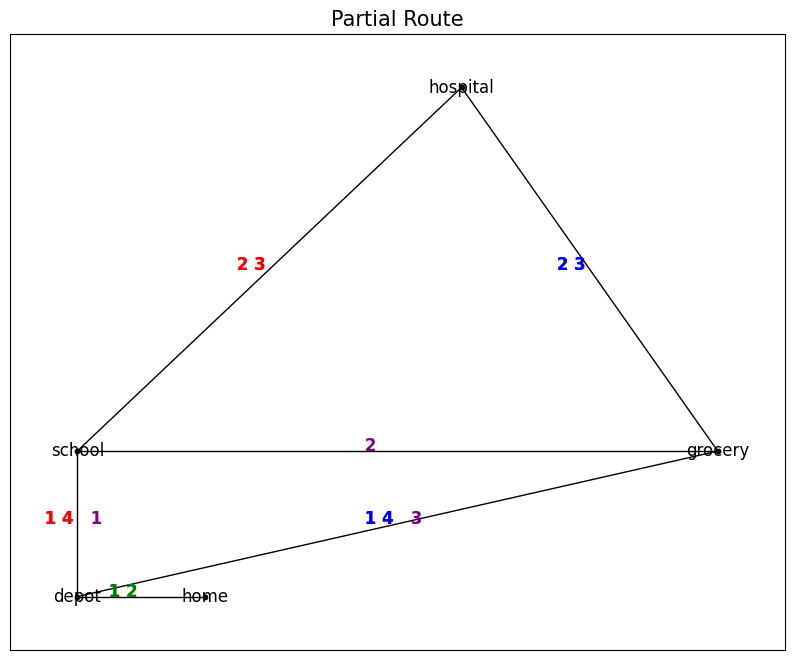

In [26]:
def plot_routes(G, routes):
    colors = ['blue', 'red', 'green', 'purple']
    nx.set_edge_attributes(G,"", "plot_sequence")

    plt.figure(figsize=(10, 8))
    nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True)

    for color, route in enumerate(routes):
        visited = []
        for i, route_step in enumerate(route):
            edge = (route_step.node1, route_step.node2)
            # if we've visited the arc already on this route, add to plot_sequence. otherwise create new
            if((edge[0], edge[1]) not in visited and (edge[1], edge[0]) not in visited):
                new_plot_sequence = ""
                for j in range(len(G[edge[0]][edge[1]]["plot_sequence"])):
                    new_plot_sequence += "  "
                G[edge[0]][edge[1]]['plot_sequence'] = new_plot_sequence + ' ' + str(i+1)
            else:
                G[edge[0]][edge[1]]['plot_sequence'] += ' ' + str(i+1)
            visited.append(edge)
        for route_step in route:
            edge = (route_step.node1, route_step.node2)
            x = (node_positions[edge[0]][0] + node_positions[edge[1]][0]) / 2 - .3
            y = (node_positions[edge[0]][1] + node_positions[edge[1]][1]) / 2
            plt.text(x, y, G[edge[0]][edge[1]]["plot_sequence"], color=colors[color], fontsize=12, fontweight = 'bold')
    plt.title('Partial Route', size=15)
    plt.show()

plot_routes(G_copy, routes)

In [27]:
def turn_penalty(edge1, edge2):
    penalties = {"straight": 0, "right": 1, "left": 2, "sharp right": 2, "sharp left": 3, "u-turn": 4}
    node1 = edge1[0]
    node2 = edge1[1]
    node3 = edge2[1]

    v_x = G.nodes[node2]['x']-G.nodes[node1]['x']
    v_y = G.nodes[node2]['y']-G.nodes[node1]['y']

    w_x = G.nodes[node3]['x']-G.nodes[node2]['x']
    w_y = G.nodes[node3]['y']-G.nodes[node2]['y']

    v = (v_x, v_y)
    w = (w_x, w_y)

    theta = angle(v,w)
    return penalties[turn_direction(theta)]

## Evaluating Tour Cost

Considerations: Priority. Number of deadheaded routes. Number of returns required to depot (total number of routes). Number of left turns. 

In [28]:
def routes_cost_updated(routes, NUMROUTES_PENALTY, DEADHEAD_PENALTY):
    cost = 0
    time = 0
    for route in routes:
        for i in range(len(route)):
            routeStep1 = route[i]
            edge = (routeStep1.node1, routeStep1.node2)

            # penalize the turn
            if i+1 < len(route):
                next_edge = (route[i+1].node1, route[i+1].node2)
                cost += turn_penalty(edge, next_edge)

            # penalize priority and distance
            edge_data = G[edge[0]][edge[1]]
            
            time += edge_data['time']
            priority_cost = edge_data['priority'] * time
            
            cost += edge_data['distance']+priority_cost
        # penalize number of returns to depot
        cost += NUMROUTES_PENALTY

    # penalize deadheading
    for edge in G.edges(data=True):
        cost += edge[2]['deadheading_passes']*DEADHEAD_PENALTY
    return cost

routes_cost_updated(routes, 1, 1)


674

## Step 3: Generate Neighborhood Routes - New approach: Backtracking Decision Tree

Approach: take an existing route as a parameter. Backtrack and make a different choice for an arc to select to get a similar but different route. Evaluate with cost function

Somehow need to keep track of the state of the graph in reverse. Do it in the route creation process

First, we create a function to undo the moves of the previous route

In [41]:
def unvisit_arc(G, route_step: RouteStep, undirected=True):
    global curr_salt
    node1 = route_step.node1
    node2 = route_step.node2

    # if we deadheaded, undo the count
    if route_step.wasDeadheaded:
        G[node1][node2]["deadheading_passes"] -= 1

    # didn't deadhead, undo everything else
    else:
        G.nodes[node1]['weighted_degree'] += G[node1][node2]['priority']
        if (undirected):
            G.nodes[node2]['weighted_degree'] += G[node1][node2]['priority']

        G[node1][node2]['passes_rem'] += 1
    
    curr_salt = route_step.saltval

    return node1

In [42]:
def finish_route(G, curr_node, full_routes: list[list[RouteStep]], part_route: list[RouteStep]):
    global curr_salt
    # define initial conditions
    alpha = 1 # set alpha parameter
    selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
    routes = full_routes.copy()
    partial_route = part_route.copy()
    while all_serviced(G) == False:
        partial_route = RCA(G, curr_node, alpha, selection_weights, partial_route)
        routes.append(partial_route)
        curr_salt = SALT_CAP
        curr_node = 'depot'
        partial_route = list()

    return routes


What do the variables look like after the route generation?

In [43]:
def print_graph_attributes(G):
    for node in G.nodes(data=True):
        print(node)

    for edge in G.edges(data=True):
        print(edge)

Generate an alternative route. ***Problem!!!!*** Salt is overflowing

In [44]:
# define initial conditions
curr_node = 'depot' # set starting node to depot
alpha = 1 # set alpha parameter
selection_weights = [0.4, 0.2, 0.4] # set weights for arc selection
G_copy = G.copy()
curr_salt = SALT_CAP
routes = []
partial_route = list() # list of tuples
number_of_routes = 0

while all_serviced(G_copy) == False:
    partial_route = RCA(G_copy, curr_node, alpha, selection_weights, partial_route)
    routes.append(partial_route)
    curr_salt = SALT_CAP
    curr_node = 'depot'
    partial_route = list()
    number_of_routes += 1

print("Number of routes:" + str(len(routes)))
for route in routes:
    for edge in route:
        print(edge)
    
    print("*****\n")

def neighbor_route(G, full_route: list[list[RouteStep]]):
    global curr_salt
    global selection_weights

    # flatten the routes so that all steps are in one massive list
    new_route = sum(full_route, [])

    route_step = new_route[-1]

    # backtrack to the last node with options
    while(route_step.hadOptions == False):
        unvisit_arc(G, route_step)
        new_route.pop()
        route_step = new_route[-1]

    # one more to get to unvist the edge that had options
    unvisit_arc(G, route_step)
    new_route.pop()
    old_route_step = route_step
    route_step = new_route[-1]

    curr_node = route_step.node2
    prev_node = route_step.node1
    # once we get there, we have to choose a different path
    # look at the rcl at that point and choose a different node to go to

    required_arcs, c_min, c_max = process_node(G, curr_node)
    rcl = [] # initialize restricted candidate list
    for edge in required_arcs:
        if cost(G, edge[0], edge[1]) >= c_min and cost(G, edge[0], edge[1]) <= c_min + alpha*(c_max-c_min) and G[edge[0]][edge[1]]['salt_per'] <= curr_salt:
            # extra check to make sure we don't go down the same path
            if not (edge[0] == old_route_step.node1 and edge[1] == old_route_step.node2):
                rcl.append(edge)

    # choose a new arc based on restricted candidate list
    
    chosen_arc = chooseArc(G, rcl, prev_node, selection_weights)
    curr_node = visit_arc(G, chosen_arc, options=False, route=new_route)

    routes_2d_list = list()

    # recreate the 2d array of routes up to the point where we switch choices
    tot_sum = 0
    for i in range(len(full_route)):
        tot_sum += len(full_route[i])
        if tot_sum > len(new_route):
            tot_sum -= len(full_route[i])
            break
        routes_2d_list.append(full_route[i])
    
    new_part_route = new_route[tot_sum:]
    
    return finish_route(G, curr_node, routes_2d_list, new_part_route)
    
routes_neighbor = neighbor_route(G_copy, routes)

Number of routes:4
depot --> school. Deadhead: False. Had options: True. Salt value: 5
school --> grocery. Deadhead: False. Had options: True. Salt value: 4
grocery --> hospital. Deadhead: False. Had options: False. Salt value: 2
hospital --> grocery. Deadhead: False. Had options: False. Salt value: 1
grocery --> depot. Deadhead: True. Had options: False. Salt value: 0
*****

depot --> grocery. Deadhead: False. Had options: True. Salt value: 5
grocery --> hospital. Deadhead: True. Had options: False. Salt value: 2
hospital --> school. Deadhead: False. Had options: False. Salt value: 2
school --> depot. Deadhead: True. Had options: False. Salt value: 0
*****

depot --> home. Deadhead: False. Had options: False. Salt value: 5
home --> depot. Deadhead: True. Had options: False. Salt value: 4
*****

depot --> school. Deadhead: True. Had options: False. Salt value: 5
school --> hospital. Deadhead: False. Had options: False. Salt value: 5
hospital --> school. Deadhead: True. Had options: Fal

In [45]:
def print_route(routes):
    for route in routes:
        for edge in route:
            print(edge)
        
        print("*****\n")
print_route(routes_neighbor)

depot --> school. Deadhead: False. Had options: True. Salt value: 5
school --> grocery. Deadhead: False. Had options: True. Salt value: 4
grocery --> hospital. Deadhead: False. Had options: False. Salt value: 2
hospital --> grocery. Deadhead: False. Had options: False. Salt value: 1
grocery --> depot. Deadhead: True. Had options: False. Salt value: 0
*****

depot --> home. Deadhead: False. Had options: False. Salt value: 5
home --> depot. Deadhead: True. Had options: False. Salt value: 4
*****

depot --> grocery. Deadhead: False. Had options: False. Salt value: 5
grocery --> hospital. Deadhead: True. Had options: False. Salt value: 2
hospital --> school. Deadhead: False. Had options: False. Salt value: 2
school --> depot. Deadhead: True. Had options: False. Salt value: 0
*****

depot --> school. Deadhead: True. Had options: False. Salt value: 5
school --> hospital. Deadhead: False. Had options: False. Salt value: 5
hospital --> school. Deadhead: True. Had options: False. Salt value: 3


Next step: plot side by side and compare

In [46]:
def plot_routes(G, routes, ax : plt.Axes):
    colors = ['blue', 'red', 'green', 'purple']
    nx.set_edge_attributes(G,"", "plot_sequence")
    nx.draw_networkx(G, pos=node_positions, node_size=10, node_color='black', with_labels=True, ax=ax)

    for color, route in enumerate(routes):
        visited = []
        for i, route_step in enumerate(route):
            edge = (route_step.node1, route_step.node2)
            # if we've visited the arc already on this route, add to plot_sequence. otherwise create new
            if((edge[0], edge[1]) not in visited and (edge[1], edge[0]) not in visited):
                new_plot_sequence = ""
                for j in range(len(G[edge[0]][edge[1]]["plot_sequence"])):
                    new_plot_sequence += "  "
                G[edge[0]][edge[1]]['plot_sequence'] = new_plot_sequence + ' ' + str(i+1)
            else:
                G[edge[0]][edge[1]]['plot_sequence'] += ' ' + str(i+1)
            visited.append(edge)
        for route_step in route:
            edge = (route_step.node1, route_step.node2)
            x = (node_positions[edge[0]][0] + node_positions[edge[1]][0]) / 2 - .3
            y = (node_positions[edge[0]][1] + node_positions[edge[1]][1]) / 2
            ax.text(x, y, G[edge[0]][edge[1]]["plot_sequence"], color=colors[color], fontsize=12, fontweight = 'bold')
    ax.set_title('Partial Route', size=15)

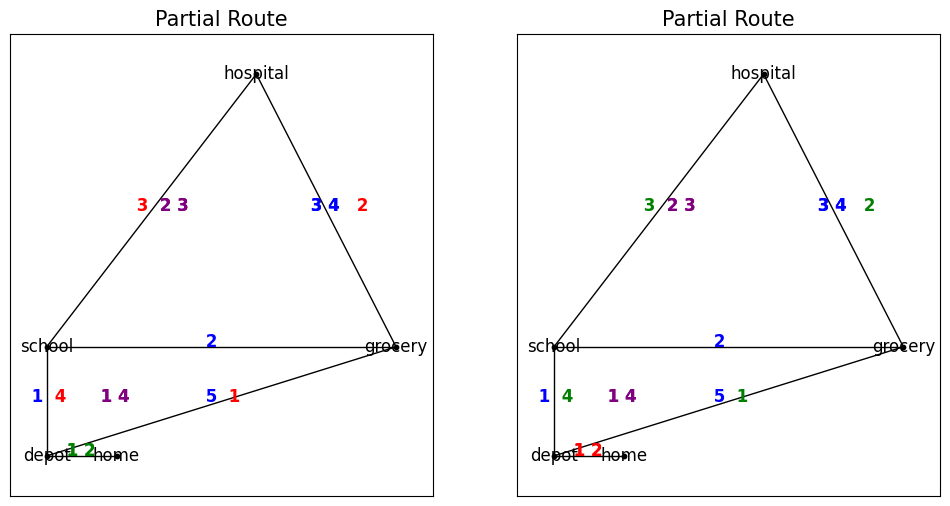

Cost comparision:
Original cost: 901
Neighbor cost: 889


In [47]:
def plot_routes_compare(G, routes):
    route1 = routes[0]
    route2 = routes[1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.set_title('Route 1', size=15)
    ax2.set_title('Route 2', size=15)
    plot_routes(G, route1, ax1)
    plot_routes(G, route2, ax2)
    plt.show()
        
plot_routes_compare(G_copy, [routes, routes_neighbor])
print("Cost comparision:")
print("Original cost:", routes_cost_updated(routes, 1, 1))
print("Neighbor cost:", routes_cost_updated(routes_neighbor, 1, 1))

## Step 3: Generate Alternative Routes - Simulated Annealing Heuristic

Principle: Initially, at high temperature, solutions with worse costs are accepted with more likelihood than later at lower temperatures, where the algorithm attempts to converage on a minimum by primarily accepting improvements. See this [reference](https://www.baeldung.com/cs/simulated-annealing) for a good explanation

Variables:
| Variable | Definition 
|:--------:|:--------:|
|  T |  Temperature |
| T<sub> min| Lowest Temperature before algorithm terminates|
|  N   |  Counter (number of iterations at the current temperature)  
|  N<sub>max   | Max number of iterations at each temperature | 
| RCA_Cost | Cost obtained from the construction heuristic|
| RCA_Routes | Set of routes obtained from construction heuristic |
|Best_Cost| Lowest cost (of the best solution)|
|Best_Routes| Route corresponding to the lowest cost
|Curr_Cost| Current cost|
|Curr_Routes| Set of routes corresponding to current cost|
|R|Random value between 0 and 1|
|SA_Cost| Simulated Annealing Cost|
|SA_Routes| Simulated Annealing route set|
|$\Delta$ TC| Value of (Curr_Cost - SA_Cost)|
|a| Temperature reduction factor (hyperparameter)|
|N_iteration| Counter (number of iterations in the heuristic)|
|Max_Iteration| Maximum number of iterations in the heuristic|




In [48]:
def simulated_annealing(a, T, T_min, N_max, Max_iterations, Initial_Cost, Initial_Routes):
    Best_Cost = Initial_Cost
    Best_Routes = Initial_Routes

    Curr_Cost = Initial_Cost
    Curr_Routes = Initial_Routes

    N_iteration = 0
    while T > T_min and N_iteration < Max_iterations:
        N = 0
        # this part is ucrrently useless because neighor_route will always generate the same thing
        while N < N_max:
            # get neighbor
            SA_route = neighbor_route(G_copy, Curr_Routes)
            SA_cost = routes_cost_updated(SA_route, 1, 1)
            delta = SA_cost - Curr_Cost
            R = random.random()
            
            if delta <= 0:
                Curr_Cost = SA_cost
                Curr_Routes = SA_route
                if Curr_Cost < Best_Cost:
                    Best_Cost = Curr_Cost
                    Best_Routes = Curr_Routes
            else:
                if R < math.exp(-delta/T):
                    Curr_Cost = SA_cost
                    Curr_Routes = SA_route
            N += 1
        N_iteration += 1
        T = a*T
        print(T)
    return Best_Routes


Initial parameters chosen based on article.

T = CostDiff/ln(.35)
CostDiff = average of all costs of edges

In [53]:
# set hyperparameters
a = .75 # temperature reduction, between 0 and 1.

T = -sum(cost(G, edge[0], edge[1]) for edge in G.edges(data=True))/math.log(.35) # initial temperature
T_min = 0.0001 # minimum temperature
N_max = 30 # max number of iteraitons at each temperature
Max_Iterations = 10000 # max number of total iterations

RCA_Cost = routes_cost_updated(routes, 1, 1)
RCA_Routes = routes

best_routes_final = simulated_annealing(a, T, T_min, N_max, Max_Iterations, RCA_Cost, RCA_Routes)

15.002541509135279
11.25190613185146
8.438929598888596
6.329197199166447
4.746897899374835
3.560173424531126
2.6701300683983447
2.0025975512987584
1.5019481634740688
1.1264611226055516
0.8448458419541638
0.6336343814656229
0.4752257860992172
0.35641933957441285
0.26731450468080964
0.20048587851060723
0.15036440888295544
0.11277330666221658
0.08457997999666243
0.06343498499749682
0.04757623874812261
0.03568217906109196
0.02676163429581897
0.020071225721864226
0.01505341929139817
0.011290064468548628
0.008467548351411471
0.006350661263558603
0.004762995947668953
0.0035722469607517146
0.0026791852205637857
0.002009388915422839
0.0015070416865671293
0.001130281264925347
0.0008477109486940103
0.0006357832115205077
0.0004768374086403808
0.0003576280564802856
0.0002682210423602142
0.00020116578177016065
0.0001508743363276205
0.00011315575224571537
8.486681418428653e-05


Print results

Original Cost 901
Final cost 594


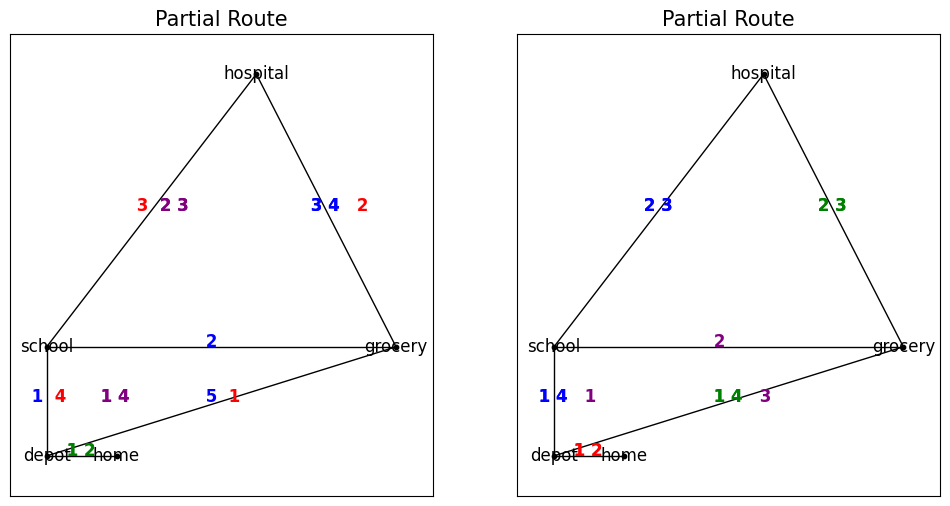

In [54]:
print("Original Cost", RCA_Cost)
print("Final cost", routes_cost_updated(best_routes_final, 1, 1))

plot_routes_compare(G_copy, [RCA_Routes, best_routes_final])

In [51]:
print_route(best_routes_final)

depot --> school. Deadhead: False. Had options: True. Salt value: 5
school --> hospital. Deadhead: False. Had options: False. Salt value: 4
hospital --> school. Deadhead: False. Had options: True. Salt value: 2
school --> depot. Deadhead: True. Had options: False. Salt value: 0
*****

depot --> grocery. Deadhead: False. Had options: True. Salt value: 5
grocery --> hospital. Deadhead: False. Had options: True. Salt value: 2
hospital --> grocery. Deadhead: False. Had options: False. Salt value: 1
grocery --> depot. Deadhead: True. Had options: False. Salt value: 0
*****

depot --> home. Deadhead: False. Had options: False. Salt value: 5
home --> depot. Deadhead: True. Had options: False. Salt value: 4
*****

depot --> school. Deadhead: True. Had options: False. Salt value: 5
school --> grocery. Deadhead: False. Had options: False. Salt value: 5
grocery --> depot. Deadhead: True. Had options: False. Salt value: 3
*****



#### Route Improvement (RI) algorithm connects the arcs in the new route (which may be disconnected after swaps)



First, we randomly choose an arc in the grpah to swap to an arbitrary position. Then, we reconnect the entire route using the same RCA algorithm with the new swap fixed in place.

In [52]:
def rand_swap(G, route):
    '''
    Randomly swaps two edges in a route
    '''
    
    new_route = route.copy()
    i,j = random.sample(range(len(route)), 2) # choose a random edge to move to a new place
    new_location = min(i, j) # get the smaller index
    arc_to_move_index = max(i, j) # get the larger index

    arc_to_move = route[arc_to_move_index] # get the arc to move
    
    if new_location == 0:
        prev_node = 'depot'
    else:
        prev_node = route[new_location-1][1]

    print("I and J are {} and {}".format(i, j))
    print("Swapping arcs {} and {}, which are labled {} and {}".format(route[new_location], route[arc_to_move_index], new_location+1,arc_to_move_index+1))

    # connect the previous node to the first node of the arc to move
    new_route = list()

    # move between all preserved edges of the old route
    for edge in route[:new_location]:
        visit_arc(G, edge, route=new_route)
    move_between_nodes(G, prev_node, arc_to_move[0], new_route)
    
    curr_node = arc_to_move[0]
    # make sure the arc we want to swap hasn't been visited in the shortest path to it

    if G[arc_to_move[0]][arc_to_move[1]]['passes'] > 0:
        curr_node = visit_arc(G, arc_to_move, route=new_route) # visit the arc
    print(new_route)
    print(process_node(G, arc_to_move[0]))

    new_route = RCA(G, curr_node, route=new_route, alpha=0.4)
    return new_route
